## Importing Libraries & Data

In [35]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px
import statsmodels.api as sm

In [4]:
#import data
df = pd.read_csv('youtube_data.csv')
categories = pd.read_csv('youtube_categories.csv')

In [5]:
#mapping category_id to category name
df = df.merge(categories, on = 'category_id', how = 'left')
df = df.drop_duplicates(subset = 'video_id')

## Data Preprocessing

Consider the formula:

$$Engagement = \frac{{\text{{Likes}} + \text{{Comments}}}}{{\text{{Views}}}}$$

This engagement metric I used is an attempt to quantify user engagement with a Youtube video. It takes into account the number of likes and comments relative to the total number of views. This allows for a fair comparison between videos with varying view counts. An assumption being made is that highly engaging videos tend to accumulate a larger number of likes and comments in relation to the number of views they receive.

An advantage to using this metric over just views, likes, or comments is that it allows us to identify videos that audiences interact with strongly, even if that video hasn't reached a broader audience. In contrast, a video with a high number of views, but a low amount of likes and comments relative to the high view count would be deemed less engaging. 

I came up with this metric on my own, and there are several limitatons to be aware of
1. Likes and Comments are weighed equally. It is possible that comments should be weighed more since it takes more effort from the user's end to comment their opinion on the video compared to simply pressing the like button.
2. Comments are weighted only by the number of comments. The quality of the comment is not taken into account.
3. This metric is susceptible to like and comment bots, which wandould artificially inflate the engagement of some videos.

One metric I wanted to add to the engagement equation was viewer retention rate of the video, but that data isn't publicly available. 


Here is a very quick sanity check to test the assumption that that highly engaging videos tend to accumulate a larger number of likes and comments in relation to the number of views they receive:

Text(1038.0163398692812, 0.5, 'Comments')

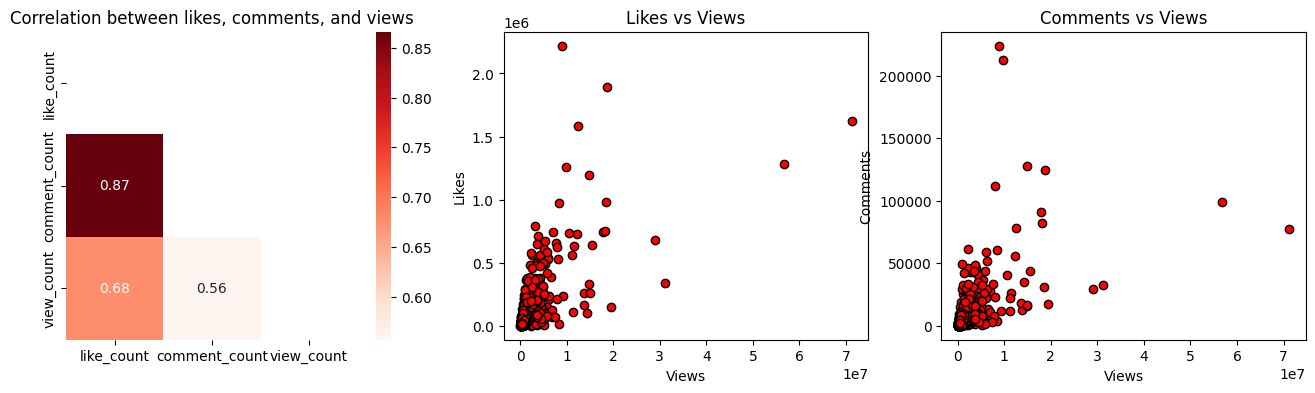

In [6]:
#figure plots
fig, ax = plt.subplots(1, 3, figsize = (16, 4))

#creating a correlation heatmap
corr = df[['like_count', 'comment_count', 'view_count']].corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot = True, cmap = 'Reds', mask = mask, ax = ax[0]);
ax[0].set_title('Correlation between likes, comments, and views');

#Likes vs Views scatterplot
ax[1].scatter(df['view_count'], df['like_count'],  color = "#FF0000", edgecolor = "black");
ax[1].set_title('Likes vs Views');
ax[1].set_xlabel('Views');
ax[1].set_ylabel('Likes')

#Comments vs Views scatterplot
ax[2].scatter(df['view_count'], df['comment_count'],  color = "#FF0000", edgecolor = "black");
ax[2].set_title('Comments vs Views');
ax[2].set_xlabel('Views');
ax[2].set_ylabel('Comments')

As shown in the correlation heatmap, comments have a moderate, positive correlation with view count. Like count and view count have a moderately strong, positive correlation. Finally like count and comment count have a strong, positive correlation. Since likes and views seem to have at least a moderate, positive correlation with views, it is reasonable to assume that comments and likes increase with respect to view count.

In [7]:
#computing engagement metric column
df['engagement'] = (df['like_count'] + df['comment_count']) / df['view_count']

In [8]:
#converting column to datetime type
df['published_at'] = pd.to_datetime(df['published_at'])

In [9]:
df.dtypes

published_at      datetime64[ns]
video_id                  object
channel_id                object
title                     object
channel_title             object
view_count                 int64
like_count                 int64
comment_count              int64
tags                      object
duration                 float64
category_id                int64
timestamp                 object
category_title            object
engagement               float64
dtype: object

In [10]:
#converting string representation of lists to lists
df['tags'] = df['tags'].apply(lambda x: eval(x))

## Measuring Video Engagment and Observing Its Trends

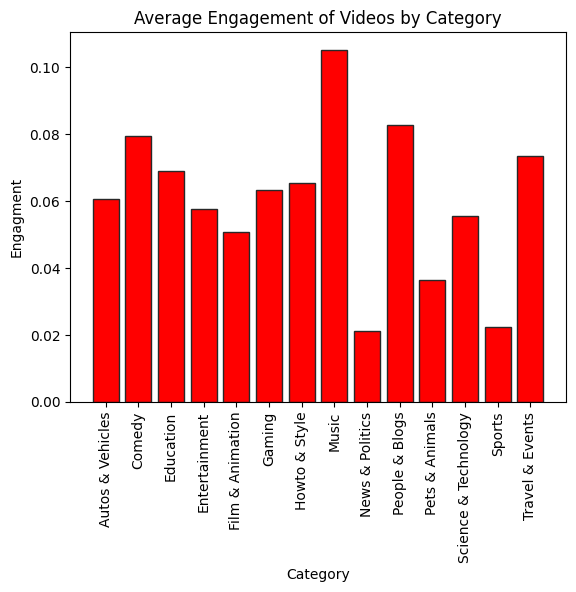

In [11]:
#Video categories with the most engagment
agg_cat = df.groupby('category_title')['engagement'].mean()
plt.bar(x = agg_cat.index, height = agg_cat, color = "#FF0000", edgecolor = '#282828');
plt.xticks(rotation=90);
plt.xlabel('Category');
plt.ylabel('Engagment');
plt.title('Average Engagement of Videos by Category');

It seems that the Music category seems to be the most engaging category according to the calculated engagement metric, while News & Politicswas the least engagement. Does that mean Youtubers who cover news and politics are not going to make videos as engaging as a music video? Well, according to this metric, yes, but context has to also be taken into account. Music videos can evoke emotions, and music videos by artists are designed to entertain and captivate viewers. This can lead to higher engagement in the form of more likes and comments. On the other hand, news & politics may naturally have less engagement, as people may only watch to get the information in the news. Additionally, the controversial topics covered in news and politics may discourage viewers from commenting and expressing their opinions. Overall, it wouldn't be completely correct to assume that a Youtuber who focuses on news and politics is going to be less engaging than a music-focused Youtuber, as engagement can naturally vary across genres.

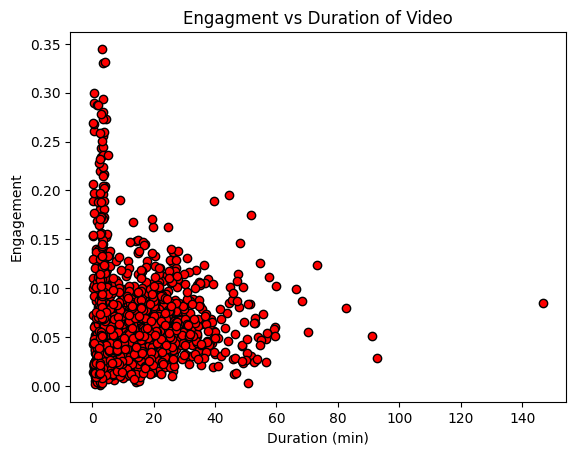

In [12]:
#Engagement vs Duration scatterplot
plt.scatter(x = df.duration, y = df.engagement, edgecolors = "black", color = "#FF0000");
plt.xlabel('Duration (min)');
plt.ylabel('Engagement');
plt.title('Engagment vs Duration of Video');

Looking at the scatterplot, it is possible that shorter videos tend to have a higher engagment on average, but a different visualization may help us make more accurate interpretations.

In [63]:
#removing outliers to bin data by duration appropriately
q1 = df.duration.quantile(0.25)
q3 = df.duration.quantile(0.75)
iqr = q3 - q1

lower_thresh = q1 - (1.5 * iqr)
upper_thresh = q3 + (1.5 * iqr)

is_not_outlier = (df['duration'] >= lower_thresh) & (df['duration'] <= upper_thresh)
df_no_outliers = df[is_not_outlier][['engagement', 'duration']].copy()

#binning data
bins = list(range(0, int(df_no_outliers['duration'].max()), 5))
df_no_outliers['duration_bin'] = pd.cut(df_no_outliers['duration'], bins)
df_no_outliers = df_no_outliers.dropna(axis = 0, how = 'any')
grouped_bins = df_no_outliers.groupby('duration_bin').mean().reset_index()

x_ticks = grouped_bins['duration_bin'].apply(lambda x : x.right)


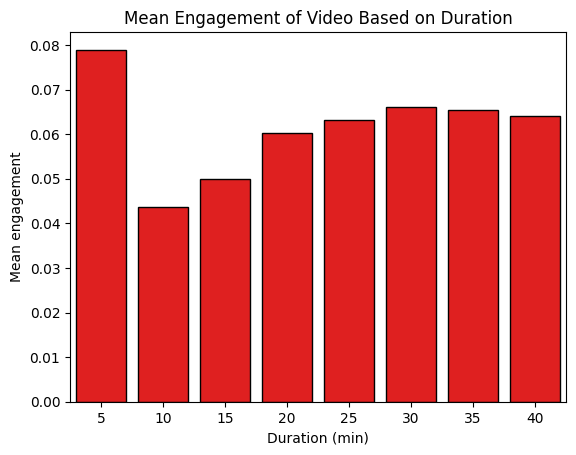

In [64]:
#barplotting average engagement based on duration of videos
sns.barplot(x = x_ticks, y = grouped_bins.engagement, edgecolor = "black", color = "#FF0000");
plt.xlabel('Duration (min)');
plt.ylabel('Mean engagement');
plt.title('Mean Engagement of Video Based on Duration');

As shown in the barplot, it seems that 0-5 minute videos tend to have the highest engagement, then engagement seems to drop from 10-15 minute videos and slowly increases as videos get longer. 

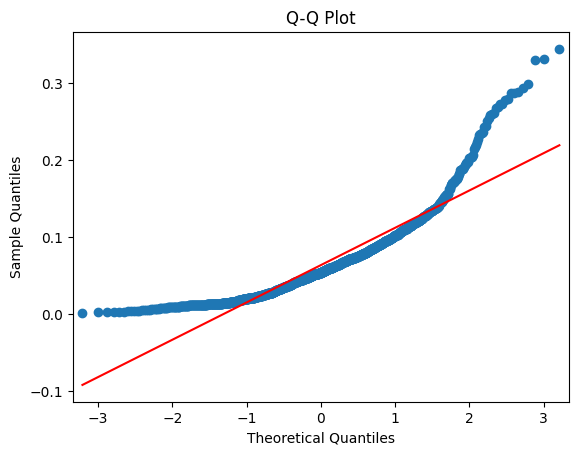

In [65]:
# Create Q-Q plot
sm.qqplot(df['engagement'], line='s')

# Add title and labels
plt.title('Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Display the plot
plt.show()


In [66]:
from scipy.stats import kruskal

# Perform the Kruskal-Wallis test
groups = [df_no_outliers.loc[df_no_outliers['duration_bin'] == bin, 'engagement'].values for bin in df_no_outliers['duration_bin'].unique()]
statistic, p_value = kruskal(*groups)

# Print the test results
print("Kruskal-Wallis test statistic:", statistic)
print("p-value:", p_value)

Kruskal-Wallis test statistic: 93.93314203146747
p-value: 1.9222242703725357e-17


In [99]:
df_no_outliers['duration_bin'] = df_no_outliers['duration_bin'].apply(lambda x : str(x))

In [100]:

# Perform pairwise comparisons using Games-Howell test
pairwise_results = pg.pairwise_gameshowell(data=df_no_outliers, dv='engagement', between='duration_bin')

# Extract the p-values for comparisons involving the (0, 5] bin
comparison_bin = '(0, 5]'  # Specify the duration bin for comparison
comparison_results = pairwise_results.loc[pairwise_results['A'] == comparison_bin]

# Set the significance level for multiple comparisons
alpha = 0.05

# Identify significant comparisons
significant_comparisons = comparison_results[comparison_results['pval'] < alpha]

# Print the significant comparisons
for _, row in significant_comparisons.iterrows():
    duration_bin = row['B']
    p_value = row['pval']
    print(f"Significantly different from {comparison_bin}: {duration_bin} (p-value: {p_value})")


Significantly different from (0, 5]: (5, 10] (p-value: 3.3861802251067274e-14)
Significantly different from (0, 5]: (10, 15] (p-value: 0.0)
Significantly different from (0, 5]: (15, 20] (p-value: 6.868881402644078e-05)
Significantly different from (0, 5]: (20, 25] (p-value: 0.0017938599798005272)
Significantly different from (0, 5]: (30, 35] (p-value: 0.03409964175752056)


## When is the best time to upload a video?

In [16]:
time_df = df[['published_at', 'view_count', 'like_count', 'comment_count', 'engagement']].copy()
time_df['published_at'] = pd.to_datetime(time_df['published_at'])

In [17]:
time_df_hour = time_df.groupby(time_df['published_at'].dt.hour).mean()

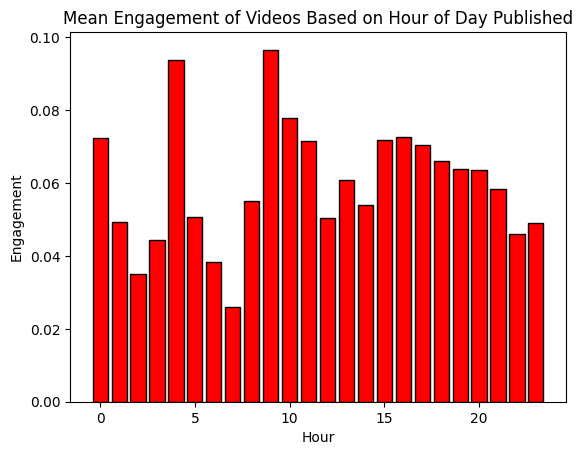

In [18]:
plt.bar(time_df_hour.index, time_df_hour['engagement'], edgecolor = "black", color = "#FF0000");
plt.xlabel('Hour');
plt.ylabel('Engagement');
plt.title('Mean Engagement of Videos Based on Hour of Day Published');

Hour 9 seems to be when the videos have the best average engagement

In [19]:
time_df_hour[time_df_hour['engagement'] == time_df_hour['engagement'].max()].index

Index([9], dtype='int32', name='published_at')

In [20]:
time_df_day = time_df.groupby(time_df['published_at'].dt.day_name()).mean()
time_df_day = time_df_day.reindex(list(pd.Series(pd.date_range('2023-01-01', periods=7)).dt.day_name()))

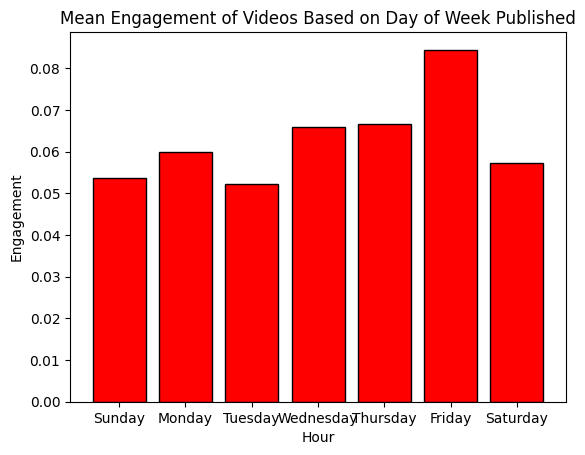

In [21]:
plt.bar(time_df_day.index, time_df_day['engagement'], edgecolor = "black", color = "#FF0000");
plt.xlabel('Hour');
plt.ylabel('Engagement');
plt.title('Mean Engagement of Videos Based on Day of Week Published');

In [22]:
time_df_day

,published_at,view_count,like_count,comment_count,engagement
published_at,,,,,
Sunday,2023-05-24 12:50:41.747572992,1.058723e+06,46485.713592,3930.194175,0.053760
Monday,2023-05-30 11:07:06.477832704,1.458760e+06,77349.448276,4941.527094,0.059852
Tuesday,2023-05-24 06:11:25.347150336,1.460222e+06,50849.435233,4055.512953,0.052216
Wednesday,2023-05-24 19:47:45.394190848,1.480140e+06,64782.294606,4850.356846,0.065893
Thursday,2023-05-26 21:11:40.438679296,1.335629e+06,81887.849057,5738.212264,0.066694
Friday,2023-05-29 15:18:50.695473152,1.122152e+06,90685.209877,6808.312757,0.084449
Saturday,2023-05-27 21:39:36.899082496,1.093975e+06,53997.986239,4293.857798,0.057245


In [23]:
time_df_month = time_df.groupby(time_df['published_at'].dt.month.map({1: 'January', 2: 'February', 3: 'March', 4: 'April',
                                            5: 'May', 6: 'June', 7: 'July', 8: 'August',
                                            9: 'September', 10: 'October', 11: 'November', 12: 'December'})).mean()


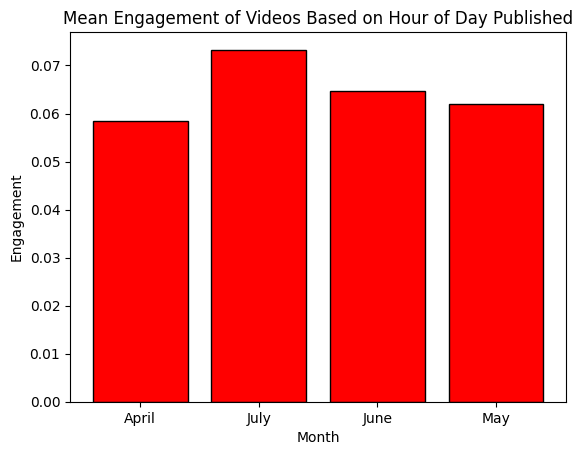

In [24]:
plt.bar(time_df_month.index, time_df_month['engagement'], edgecolor = "black", color = "#FF0000");
plt.xlabel('Month');
plt.ylabel('Engagement');
plt.title('Mean Engagement of Videos Based on Hour of Day Published');

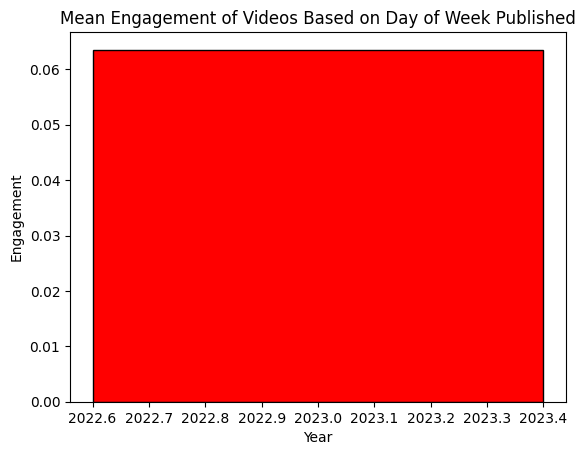

In [25]:
time_df_year = time_df.groupby(time_df['published_at'].dt.year).mean()
plt.bar(time_df_year.index, time_df_year['engagement'], edgecolor = "black", color = "#FF0000");
plt.xlabel('Year');
plt.ylabel('Engagement');
plt.title('Mean Engagement of Videos Based on Day of Week Published');


## Does the number of tags affect engagment?

## Most Popular Trending Categories

In [26]:
df.groupby(by = [df['published_at'].dt.day,'category_title'])['category_title'].count()

published_at  category_title  
1             Autos & Vehicles     2
              Comedy               2
              Education            2
              Entertainment       11
              Film & Animation     1
                                  ..
31            Gaming               5
              Music                6
              News & Politics      1
              People & Blogs       3
              Sports               2
Name: category_title, Length: 293, dtype: int64

In [27]:
df['category_title'].unique()

array(['Music', 'Sports', 'Entertainment', 'People & Blogs',
       'Science & Technology', 'Comedy', 'Film & Animation', 'Gaming',
       'Howto & Style', 'Education', 'News & Politics', 'Travel & Events',
       'Autos & Vehicles', 'Pets & Animals'], dtype=object)